# Анализ результатов A/B-тестирования 

Задача: приоритизировать гипотезы для увеличения выручки, проанализировать результаты A/B-тестирования маркетинговой гипотезы интернет-магазина.

Описание данных:

**1. Таблица hypothesis**
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**2. Таблица orders**
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

**3. Таблица visitors**
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста



In [1]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Изучение данных и подготовка к анализу

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150  
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
other_date_paser = lambda x: datetime.strptime(x, "%Y-%m-%d")
orders = pd.read_csv('/datasets/orders.csv',parse_dates = ['date'], date_parser = other_date_paser)
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Пропусков в данных нет.

In [5]:
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates = ['date'], date_parser = other_date_paser)
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Пропусков в данных нет.

Проверим правильность разделения пользователей на группы.

In [7]:
users = orders.groupby('visitorId').agg({'group':['nunique','unique']})
users.columns = ['groups','group_names']
print(len(users))
users = users.query('groups>1')
display(users.head(5))
len(users)

1031


,groups,group_names
visitorId,,
8300375,2,"[B, A]"
199603092,2,"[A, B]"
232979603,2,"[B, A]"
237748145,2,"[B, A]"
276558944,2,"[B, A]"


58

58 пользователей попали в обе группы теста, все они относятся к пользователям, совершившим заказы - около 5% от всех покупателей. В идеале разделение пользователей на группы нужно проверять до начала теста, таких ситуаций быть не должно. Исправить факт попадания пользователей в обе группы мы не можем. Удаление этих пользователей, ровно как и оставление их не окажет влияния на проверяемые нами гипотезы о равенстве/различии выборок. Другой момент, что мы не знаем, действительно ли они находились в обеих группах или это сбой при заполнении данных и пользователи в обе группы не попадали, во втором случае это заведомо искажает полученные в ходе теста данные.


## Приоритизация гипотез

Проверять все гипотезы затратно по времени и финансам. Для выбора гипотезы, с максимально ожидаемым улучшением ключевых метрик бизнеса, сформулированные гипотезы приоритизируем. Используем методы ICE и RICE.

### ICE

ICE = (Impact x Confidence)/ Efforts

In [8]:
hypothesis['ICE'] = round((hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts'],1)
hypothesis['Rank_ICE'] = hypothesis['ICE'].rank(ascending = 0)
hypothesis[['ICE', 'Hypothesis']].sort_values(by = 'ICE', ascending = False)

,ICE,Hypothesis
8,16.2,"Запустить акцию, дающую скидку на товар в день рождения"
0,13.3,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
7,11.2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
6,8.0,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"
2,7.0,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
1,2.0,"Запустить собственную службу доставки, что сократит срок доставки заказов"
5,1.3,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
3,1.1,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
4,1.0,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"


При оценке по методике ICE наивысший приоритет у гипотезы **"Запустить акцию, дающую скидку на товар в день рождения"**. 

На втором и третьем местах с довольно высокими приоритетами гипотезы: 
"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и 
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" соответственно.

### RICE

Методика подсчетв RICE отличается добавлением параметра Reach — скольких пользователей затронет изменение.

RICE = (Reach х Impact x Confidence)/ Efforts

In [9]:
hypothesis['RICE'] = round((hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts'],1)
hypothesis['Rank_RICE'] = hypothesis['RICE'].rank(ascending = 0)
hypothesis[['Hypothesis','RICE']].sort_values(by = 'RICE', ascending = False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


При оценке по методике RICE наивысший приоритет у гипотезы **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"**, причем её "отрыв" от последующих гипотез значительный, показатель RICE в 2 раза выше, чем у следующей гипотезы. Из таблицы также видно, что она имеет наибольший Reach так как охватывает всех пользователей. 

Гипотеза лидировавшая при подсчете ICE лишь на 5 месте, несмотря на бόльшие Impact и Confidence, её охват пользователей наименьший, возможно конец года и у большинства пользователей день рождения прошел, либо в профилях большинства пользователей не указана дата рождения.

In [10]:
hypothesis[['Hypothesis','Rank_ICE','Rank_RICE']].style.highlight_min(color='coral')  

,Hypothesis,Rank_ICE,Rank_RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",2,3.5
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",6,7.5
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",5,2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,6
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",9,9
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",7,7.5
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",4,3.5
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",3,1
8,"Запустить акцию, дающую скидку на товар в день рождения",1,5


### Вывод

При проведении приоритизации гипотез охват пользователей имеет большое влияние наряду с оказываемым влиянием и уверенностью. Так при гипотезе с малым охватом пользователей, на выходе можно не получить статистически значимый прирост метрик, несмотря на высокое оказываемое влияние и уверенность.

Поэтому в данном случае целесообразнее выбрать гипотезу, лидирующую по RICE - **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".**

## Анализ A/B-теста

Для анализа результатов теста оценим изменение кумулятивных метрик за период его проведения, таких как: выручка, средний чек и конверсия.

Создадим датафреймы из таблиц с кумулятивными по дням заказами и посетителями.

In [11]:
# выделим уникальные пары дата-группа теста
data_groups = orders[['date','group']].drop_duplicates()

In [12]:
# таблица с кумулятивными по дням заказами
orders_aggregated = data_groups.apply\
         (lambda x: orders[np.logical_and(orders['date']<= x['date'], orders['group']== x['group'])]\
         .agg({'date':'max','group':'max','transactionId':'nunique','visitorId':'nunique', 'revenue':'sum'}), axis = 1,)\
          .sort_values(by = ['date','group'])

In [13]:
# таблиц с кумулятивными по дням посетителями
visitors_aggregated = data_groups.apply\
        (lambda x: visitors[np.logical_and(visitors['date']<= x['date'], visitors['group']== x['group'])]\
         .agg({'date':'max','group':'max','visitors':'sum'}), axis = 1).sort_values(by = ['date','group'])

In [14]:
# объединим таблицу в одну
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on = ['date','group'], right_on = ['date','group'])
cumulative_data.columns = ['date','group','orders','buyers','revenue','visitors']

In [15]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Теперь можно строить графики необходимых кумулятивных метрик.

### Кумулятивная выручка 

Построим график кумулятивной выручки для каждой группы  и сравним.

In [16]:
# выделим данные для группы А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

In [17]:
# выделим данные для группы B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

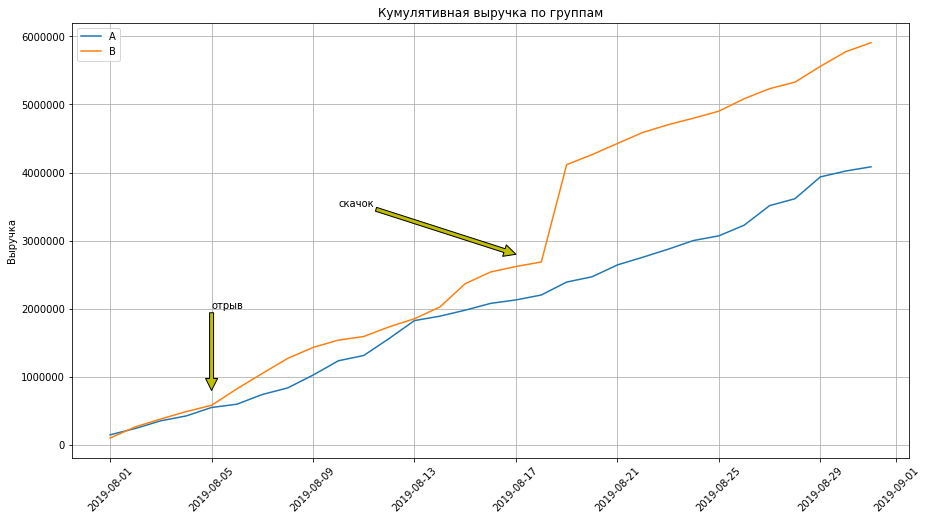

In [18]:
plt.figure(figsize=(15, 8))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A ['revenue'], label = 'A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B ['revenue'], label = 'B')
plt.xticks(rotation = 45)
plt.grid()
plt.title('Кумулятивная выручка по группам')
plt.ylabel('Выручка')
plt.legend() 
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='y'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='y'))
plt.show()

Выручка равномерно увеличивалась в обеих группах в первой половине теста, причем выручка в группе В была несколько выше. После 17.08.2019 выручка в группе А продолжила увеличиваться в соответствии с тенденцией в первой половине теста, а выручка в группе В резко увеличилась - приюлизительно в 1,5 раза (270 тыс.-410 тыс.) и затем продолжила расти равномерно, таким образом к концу месяца превысив кумулятивную выручку приблизительно в 1,4 раза (410 тыс.- 590 тыс.).

Делать выводы на основании только кумулятивной выручки рано, возможно такой резкий прирост выручки обусловлен какими-то особо крупными или дорогими заказами, которые являются аномалией. Для начала посмотрим как себя ведет график кумулятивного среднего чека.

### Кумулятивный средний чек

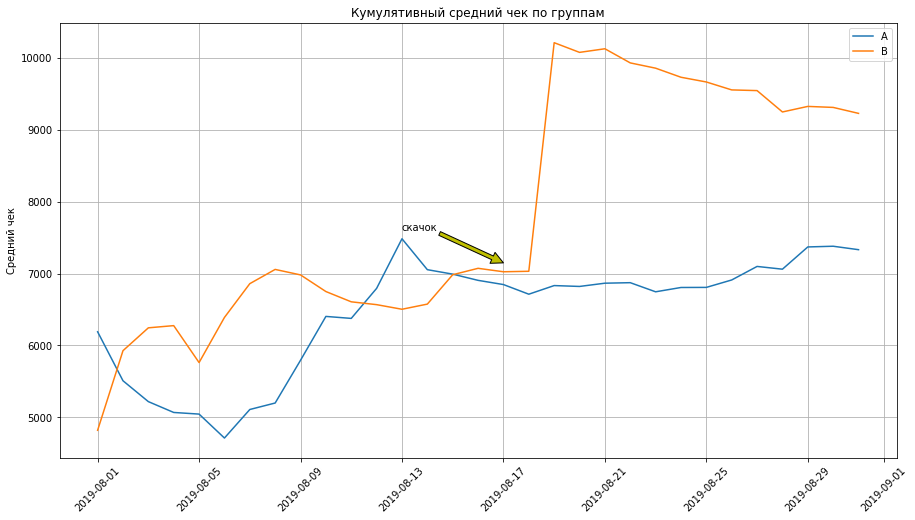

In [19]:
plt.figure(figsize=(15, 8))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A ['revenue']/cumulative_revenue_A ['orders'], label = 'A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B ['revenue']/cumulative_revenue_B ['orders'], label = 'B')
plt.xticks(rotation = 45)
plt.grid()
plt.title('Кумулятивный средний чек по группам')
plt.ylabel('Средний чек')
plt.legend() 
plt.annotate('скачок', xy=('2019-08-17', 7150), xytext=('2019-08-13', 7600),
            arrowprops=dict(facecolor='y'))
plt.show()

Графики среднего чека также растут во время всего периода проведения теста. При этом для группы А рост в первой половине более резкий, а во второй половине происходит "стабилизация" на уровне около 7000. Группа В демонстрирует схожий с группой А рост в первой половине теста, но более неравномерныйб "скачкообразный", к середине теста несколько снижается относительно группы А,
а затем после 17.08.2019 происходит резкий скачок более чем в 1,5 раза (7000 - 11000), с последующей стабилизацией и тенденцией к снижению. В конце месяца средний чек группы В превышает средний чек группы А приблизительно в 1,2 раза (9200 и 7400 соответственно).

Такое поведение графика среднего чека подтверждает наше предположении о наличии аномально дорогих заказов в группе В после 17.08.2019. Таким образом среднему чеку группы В могло не хватить времени выйти на реальный уровень среднего чека после всплеска и при продолжении теста мы бы отметили дальнейшее снижение графика. В связи с этим оцека по сырым данным не отражает реальную картину, необходимо оценить средний чек по группам без учетов выбросов.

Учитывая, что графики кумулятивного среднего чека трижды пересекаются, чтобы нагляднее увидеть разницу между группами, построим график относительного различия.

In [20]:
# соберем данные в один датафрейм
merged_cumulative_revenue = cumulative_revenue_A\
              .merge(cumulative_revenue_B, left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A','B'])
merged_cumulative_revenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


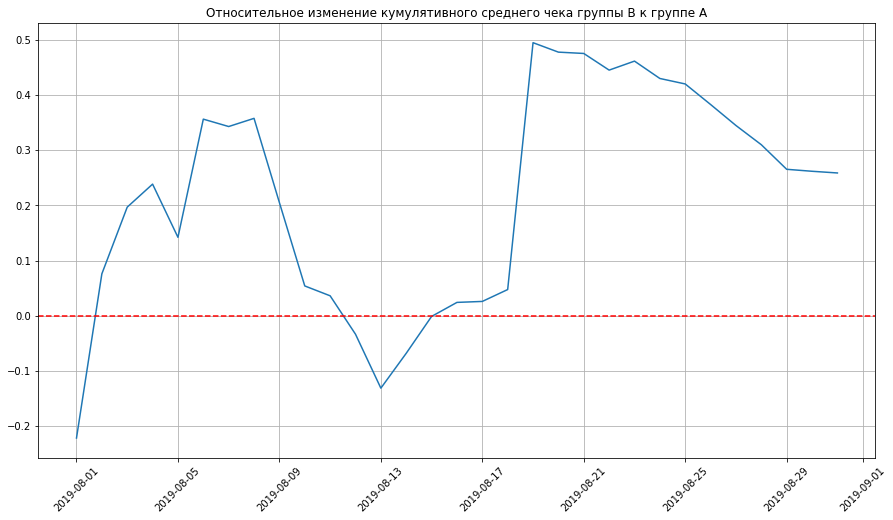

In [21]:
plt.figure(figsize=(15, 8))
plt.plot(merged_cumulative_revenue['date'],(merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])
         /(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)
plt.axhline(y=0, color='red', linestyle='--') 
plt.xticks(rotation = 45)
plt.grid()
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show()

Здесь также отмечается "скачкообразный" характер графика с большими всплесками и эпизодом снижения,что также косвенно указывает на выбросы в данных. Исследуем их позже. Для начала посмотрим конверсию по группам на "сырых" данных.

### Кумулятивная конверсия

In [22]:
# посчитаем кумулятивную конверсию 
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
# разделяем по группам
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

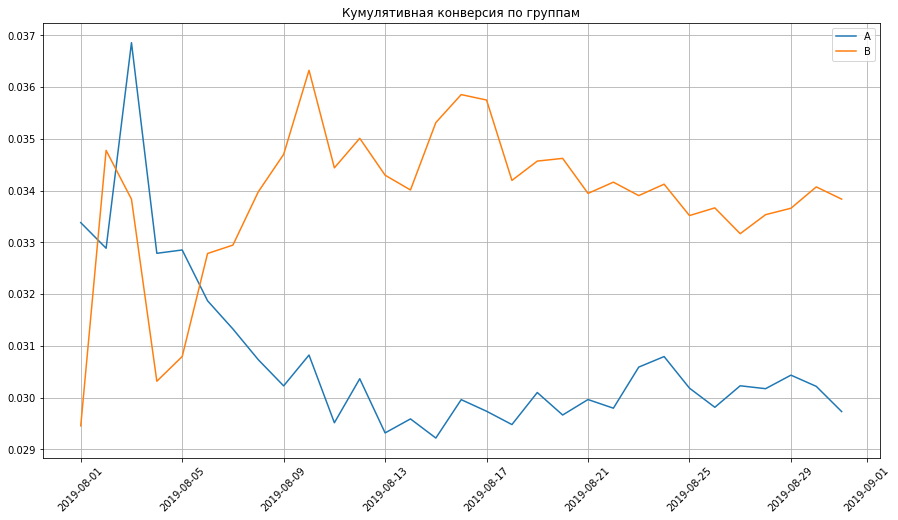

In [23]:
plt.figure(figsize=(15, 8))
plt.plot(cumulative_data_A['date'],cumulative_data_A['conversion'], label = 'A')
plt.plot(cumulative_data_B['date'],cumulative_data_B['conversion'], label = 'B')
plt.legend()
plt.title('Кумулятивная конверсия по группам')
plt.xticks(rotation = 45)
plt.grid()

В первые дни кумулятивная конверсия в обеих группах после резкого роста пошла на спад, при этом группа В показывала меньшие показатели, затем после 05.08.2019 конверсия в группе В стала увеличиваться, а в группе А снижаться, после чего произошла некоторая стабилизация и к концу месяца конверсия группы В первысила конверсию группы А. 

Чтобы нагляднее увидеть разницу между группами, построим график относительного различия.

In [24]:
# соберем данные в один датафрейм
merged_cumulative_conversion = cumulative_data_A[['date','conversion']]\
.merge(cumulative_data_B[['date','conversion']], left_on = 'date', right_on = 'date', how = 'left',suffixes = ['A','B'])

In [25]:
merged_cumulative_conversion.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


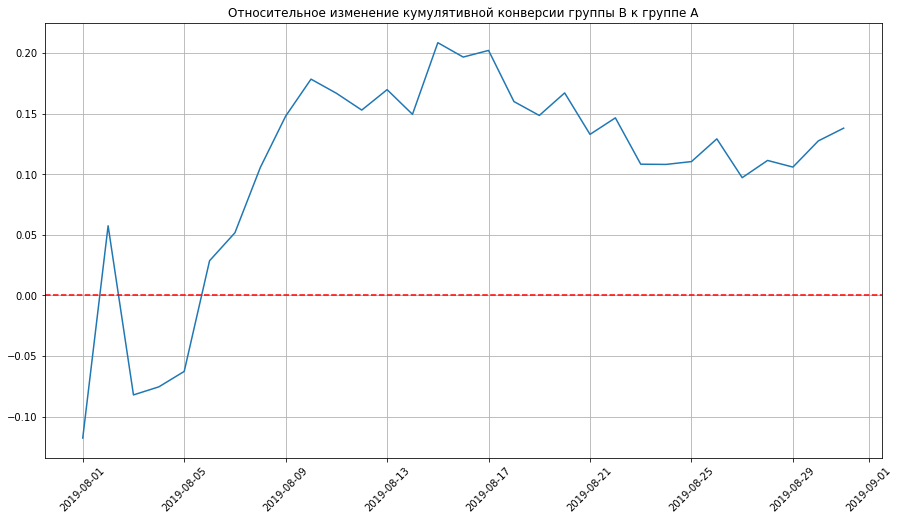

In [26]:
plt.figure(figsize=(15, 8))
plt.plot(merged_cumulative_conversion['date'], (merged_cumulative_conversion['conversionB']
         /merged_cumulative_conversion['conversionA'])-1)
plt.axhline(y=0, color='red', linestyle='--') 
plt.xticks(rotation = 45)
plt.grid()
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.show()

В начале теста группа B уступала группе A, затем после 05.08.2019 кумулятивная конверсия стала расти. График зигзагообразный с тенденцией к снижению и росту в разных сегментах, в целом конверсия ещё не стабилизировалась на каком-то урвоне, делать выводы в такой ситуации не совсем верно.

Проверим данные на выбросы, может при анализе "очищенных" данных ситуация изменится.


### Вывод

При анализе исходных данных группа В лидирует к концу исследуемого периода по всем метрикам (кумулятивная выручка, кумулятивный средний чек и кумулятивная конверсия), но нельзя не отметить резкие скачки в поведении первых двух метрик группы В в одно и то же время, что свидетельствует о выбросах в данных (аномально большие и/или дорогие заказы). Целесообразно оценить распределение заказов и их стоимости, очистить данные от выбросов и снова посмотреть на различия в оцениваемых метриках для того, чтобы сформировать корректные выводы по результатам теста.

### Количество заказов 

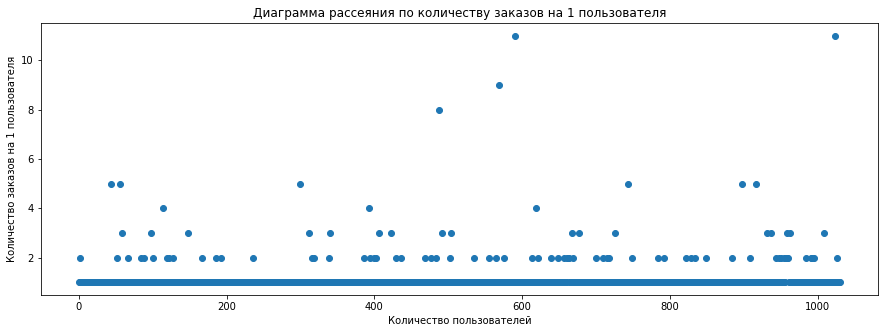

In [27]:
# Построим точечную диаграмму количества заказов по пользователям
orders_by_users = (orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'}))
orders_by_users.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0,len(orders_by_users)))
plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders_by_users['orders']) 
plt.title('Диаграмма рассеяния по количеству заказов на 1 пользователя')
plt.ylabel('Количество заказов на 1 пользователя')
plt.xlabel('Количество пользователей')
plt.show()

Согласно графику наибольшее количество пользователей с 1-2 заказами, но можно ли считать заказы больше 2 аномалиями? Проверим с помощью перцентилей.

In [28]:
np.percentile(orders_by_users['orders'], [95, 99]) 

array([2., 4.])

Не более 5% пользователей оформляли больше чем 2 заказа, не более 1% пользователей оформляли больше чем 4 заказа. Таким образом можно установить границу для определения аномальных пользователей на уровне 3.

### Стоимость заказов

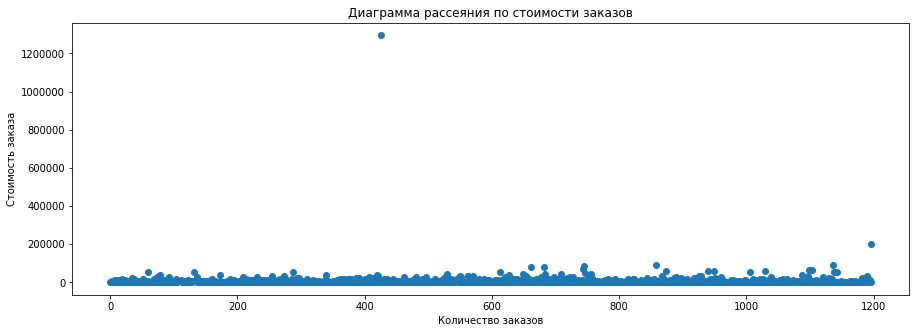

In [29]:
# Построим точечную диаграмму стоимостей заказов 
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders['revenue'])
plt.title('Диаграмма рассеяния по стоимости заказов')
plt.ylabel('Стоимость заказа')
plt.xlabel('Количество заказов')
plt.show()

В данном случае выбросов на графике не так много, но разбром графика большой, точки внизу слились, выводы не информативныю Воспользуемся перцентилями.

In [30]:
np.percentile(orders['revenue'], [95, 99]) 

array([28000. , 58233.2])

Не более 5% пользователей оформляли заказ дороже 28.000, не более 1% пользователей оформляли заказ дороже  58233.2. Таким образом можно установить границу для определения аномальных пользователей на уровне 28000.

### "Сырые" данные

Сначала посчитаем статистическую значимость различий в среднем чеке и конверсии между группами по исходным данным. Затем после удаления аномальных пользователей - по "очищенным".

#### Cтатистическая значимость различий в конверсии 

In [31]:
# Создадим датафреймы по группам, в которых для пользователей, которые заказывали хотя бы 1 раз, 
# укажем число совершённых заказов
orders_by_users_A = (orders[orders['group'] == 'A'].groupby('visitorId', as_index = False)\
                      .agg({'transactionId':pd.Series.nunique}))
orders_by_users_A.columns = ['visitorId', 'orders']

In [32]:
orders_by_users_B = (orders[orders['group'] == 'B'].groupby('visitorId', as_index = False)\
                      .agg({'transactionId':pd.Series.nunique}))
orders_by_users_B.columns = ['visitorId', 'orders']

Чтобы оценить данные по группам нужно знать общее количество посетителей по группам в день, из него вычесть количество заказов совершенных в группе - узнаем число посетителей из группы, не совершивших заказ.
Затем создадим Series, в котором пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули


In [33]:
sampleA = pd.concat([orders_by_users_A['orders'], 
          pd.Series(0, index = np.arange(visitors.query('group =="A"')['visitors'].sum() - len(orders_by_users_A['orders'])),
          name = 'orders')], axis = 0)

In [34]:
sampleB = pd.concat([orders_by_users_B['orders'], 
          pd.Series(0, index = np.arange(visitors.query('group =="B"')['visitors'].sum() - len(orders_by_users_B['orders'])),
          name = 'orders')], axis = 0)

Нулевая гипотеза - между выбороками с количеством заказов пользователей групп А и В нет разницы. 

Альтернативная гипотеза - выборки различаются.

Для проверки гипотезы будем использовать непараметрический тест Уилкоксона-Манна-Уитни, чтобы минимизировать влияние выбросов в данных на результат. 

Уровень значимости = 0.05. 


В получившихся Series длина выборки - количество посетителей, сумма - количество заказов, таким образом конверсию можно расчитать методом mean().Также выведем относительный прирост конверсии группы B.

In [35]:
print('p-value:',"{0:.4f}".format(st.mannwhitneyu(sampleA, sampleB)[1], alternative = 'two-sided'))

print('Относительный прирост конверсии группы B:',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


p-value: 0.0084
Относительный прирост конверсии группы B: 0.138


##### Вывод

По исходным данным различия в конверсии групп A и B есть.
p-value меньше 0.05. Данные, имеющихся выборок предоставляют достаточное основание для выбранного уровня значимости отвергнуть нулевую гипотезу о равенстве конверсий и принять альтернативную гипотезу об их неравенстве.

Относительный прирост конверсии группы B равен 13.8%

#### Статистическая значимость различий в среднем чеке заказа 

Нулевая гипотеза - между выборками со стоимостью заказов пользователей групп А и В нет разницы. 

Альтернативная гипотеза - выборки различаются.

Для проверки гипотезы будем использовать непараметрический тест Уилкоксона-Манна-Уитни, чтобы минимизировать влияние выбросов в данных на результат. 

Уровень значимости = 0.05. 

In [36]:
print('p-value:',
      '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1],
                       alternative = 'two-sided'))
print('Относительный прирост среднего чека группы B:',
    '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.365
Относительный прирост среднего чека группы B: 0.259


##### Вывод


По исходным данным различий в среднем чеке групп A и B нет. p-value больше 0.05. Данные, имеющихся выборок предоставляют достаточное основание для выбранного уровня значимости принять нулевую гипотезу о равенстве средних чеков и отвергнуть альтернативную гипотезу об их неравенстве.

Однако относительный прирост среднего чека группы B равен 25.9%, но разница статистически не значима.

### "Очищенные" данные

Чтобы "очистить" данные от выбросов нужно найти пользователей, севершивших аномально дорогие или аномально много заказов, и исключить их из анализа

In [37]:
# выделим пользователей с большим количеством заказов
users_many_orders= pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 3]['visitorId'],
        orders_by_users_B[orders_by_users_B['orders'] > 3]['visitorId'],
    ],
    axis=0,
)
# выделим пользователей с дорогими заказами
users_expensive_orders = orders[orders['revenue'] > 28000]['visitorId']
#объединим в один список, исключив повторения
abnormal_users = (
    pd.concat([users_many_orders, users_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users.shape 

(63,)

Всего 63 пользователя являются "аномальными", исключим их из данных перед проверкой гипотез.

####  Cтатистическая значимость различий в конверсии 

In [38]:
sampleA_filter = pd.concat([orders_by_users_A[np.logical_not(orders_by_users_A['visitorId'].isin(abnormal_users))]['orders'], 
          pd.Series(0, index = np.arange(visitors.query('group =="A"')['visitors'].sum() - len(orders_by_users_A['orders'])),
          name = 'orders')], axis = 0)

In [39]:
sampleB_filter = pd.concat([orders_by_users_B[np.logical_not(orders_by_users_B['visitorId'].isin(abnormal_users))]['orders'], 
          pd.Series(0, index = np.arange(visitors.query('group =="B"')['visitors'].sum() - len(orders_by_users_B['orders'])),
          name = 'orders')], axis = 0)

Нулевая гипотеза - между выбороками с количеством заказов пользователей групп А и В из "отфильтрованных" данных нет разницы. 

Альтернативная гипотеза - выборки различаются.

Для проверки гипотезы будем использовать непараметрический тест Уилкоксона-Манна-Уитни. 
Уровень значимости = 0.05. 

In [40]:
print('p-value:',"{0:.4f}".format(st.mannwhitneyu(sampleA_filter, sampleB_filter)[1], alternative = 'two-sided'))

print('Относительный прирост конверсии группы B:',"{0:.3f}".format(sampleB_filter.mean() / sampleA_filter.mean() - 1))

p-value: 0.0090
Относительный прирост конверсии группы B: 0.148


##### Вывод

По "очищенным" данным различия в конверсии групп A и B есть. p-value меньше 0.05. Данные, имеющихся выборок предоставляют достаточное основание для выбранного уровня значимости отвергнуть нулевую гипотезу о равенстве конверсий и принять альтернативную гипотезу об их неравенстве.

Относительный прирост конверсии группы B равен 14.8%.

Данные совпадают с двнными по исходной выборки: сохраняется статистическая значимость различия конверсий двух групп и несколько увеличиля относительный прирост конверсии н=группы В.

#### Статистическая значимость различий в среднем чеке заказа 

Нулевая гипотеза - между выборками со стоимостью заказов пользователей групп А и В из "отфильтрованных" данных нет разницы. 

Альтернативная гипотеза - выборки различаются.

Для проверки гипотезы будем использовать непараметрический тест Уилкоксона-Манна-Уитни. 
Уровень значимости = 0.05. 

In [41]:
print('p-value:',
    '{0:.3f}'.format(st.mannwhitneyu(
            orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormal_users)),)]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormal_users)),)]['revenue'],
        )[1], alternative = 'two-sided'
    )
)
print('Относительный прирост среднего чека группы B:',
 '{0:.3f}'.format(
     orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormal_users)),)]['revenue'].mean()/
     orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormal_users)),)]['revenue'].mean()-1)) 

p-value: 0.488
Относительный прирост среднего чека группы B: -0.017


##### Вывод

По "очищенным" данным различий в среднем чеке групп A и B нет. p-value больше 0.05. Данные, имеющихся выборок предоставляют достаточное основание для выбранного уровня значимости принять нулевую гипотезу о равенстве средних чеков и отвергнуть альтернативную гипотезу об их неравенстве.

Однако после удаления аномальных значений относительный прирост среднего чека группы B стал убытком -1,7% относительно группы А. Но и эта разница статистически не значима.

## Решение по результатам теста 

По результатам теста принято решение: "Остановить тест, зафиксировать победу группы В". 
По условиям неизвестно на какую метрику прежде всего были направлены изменения в проверяемой гипотезе. Но статистически значимые различия в конверсии двух групп с относительным приростом конверсии группы в 14.8%, несмотря на отсутствие статистически значимых различий в среднем чеке позволяет признать результативность изменений.

## Вывод

1. При проведении приоритизации гипотез охват пользователей имеет большое влияние наряду с оказываемым влиянием и уверенностью. Так при гипотезе с малым охватом пользователей, на выходе можно не получить статистически значимый прирост метрик, несмотря на высокое оказываемое влияние и уверенность.                                                                                     
В данном случае целесообразнее выбрать гипотезу, лидирующую по RICE - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

2. При анализе исходных данных группа В лидирует к концу исследуемого периода по всем метрикам (кумулятивная выручка, кумулятивный средний чек и кумулятивная конверсия), но отмечаются резкие скачки в поведении первых двух метрик группы В. 

3. После очистки данных от аномальных значений:

* Различия выборок с количеством заказов пользователей групп А и В статистически значимы. Относительный прирост конверсии группы B равен 14.8%.

* Выборки со стоимостью заказов пользователей групп А и В не имеют различий для выбранного уровня значимости. Имеется относительный убыток среднего чека группы B: -1,7% относительно группы А, но эта разница статистически не значима.

4. По результатам теста принято решение: "Остановить тест, зафиксировать победу группы В".